In [1]:
from datetime import datetime
import logging
import numpy as np
import os

from modules import Links
from modules import training_new as training
from modules import plotting_new as plotting
from modules import SequenceRepresentation
#from modules import sequtils as su
#from modules import Streme

logging.basicConfig(level=logging.DEBUG)

2024-07-11 15:47:11.636441: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 15:47:11.641664: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 15:47:11.700882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 15:47:12.678322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
traindir = '/home/ebelm/genomegraph/runs/20240628_modelVsStreme_newCodebaseTest_gpu'

import json
with open(os.path.join(traindir, 'evaluator.json')) as fh:
    d = json.load(fh)

from modules import Links
t = d[0]

genomes_file = os.path.join(traindir, 'allGenomes.json')
all_genomes = SequenceRepresentation.loadJSONGenomeList(genomes_file)

seqIDsToGenomes = {all_genomes[gidx][sidx].id: (gidx, sidx) \
                           for gidx in range(len(all_genomes)) \
                           for sidx in range(len(all_genomes[gidx]))}

subGenomes = []
for genome in t['links'][0]['genomes']:
    subGenomes.append([])
    for seqID in genome:
        assert seqID in seqIDsToGenomes, f"Sequence ID {seqID} not found in allGenomes."
        gidx, sidx = seqIDsToGenomes[seqID]
        subGenomes[-1].append(all_genomes[gidx][sidx])

links = [Links.linkFromDict(l, subGenomes) for l in t['links']],
print(f"{type(links)=}")
print(f"{type(links[0])=}")

In [3]:
genomes_file = os.path.join(traindir, 'allGenomes.json')
model_eval_file = os.path.join(traindir, 'evaluator.json')
streme_eval_file = os.path.join(traindir, 'streme_evaluator.json')

_dbg_ts_1 = datetime.now()
all_genomes = SequenceRepresentation.loadJSONGenomeList(genomes_file)

_dbg_ts_2 = datetime.now()
print(f"Time for loading genomes: {_dbg_ts_2 - _dbg_ts_1}")

model_eval = training.loadMultiTrainingEvaluation(model_eval_file, all_genomes, recalculate=False, unsafe=True) \
                if os.path.isfile(model_eval_file) else None

_dbg_ts_3 = datetime.now()
print(f"Time for loading model_eval: {_dbg_ts_3 - _dbg_ts_2}")
streme_eval = training.loadMultiTrainingEvaluation(streme_eval_file, all_genomes, recalculate=False, unsafe=True) \
                if os.path.isfile(streme_eval_file) else None

_dbg_ts_4 = datetime.now()
print(f"Time for loading streme_eval: {_dbg_ts_4 - _dbg_ts_3}")


Time for loading genomes: 0:00:41.516912
Time for loading model_eval: 0:00:01.253978
Time for loading streme_eval: 0:00:00.375953


In [4]:
def findSeq(seqID, all_genomes=all_genomes):
    for genome in all_genomes:
        for seq in genome:
            if seq.id == seqID:
                return seq
            
    print("[ERROR] Sequence not found in all_genomes")
    return None

In [5]:
if False: # with new Specificity, this is not needed anymore? I guess?
      # filter out runs that contain repeat-motifs -> proxy: integer overflow in nlinks or nlinksThatHit
      for eval in [model_eval, streme_eval]:
            discard = [e for e in eval.trainings if e.nlinks < 0 or e.nlinksThatHit < 0]
            print(f"Discarding {len(discard)} runs with",
                  "integer overflow in nlinks or nlinksThatHit:",
                  f"{[(f'{e.runID}: {e.nlinks} links, {e.nlinksThatHit} linksThatHit') for e in discard]}")
            
            eval.trainings = [e for e in eval.trainings if e.nlinks >= 0 and e.nlinksThatHit >= 0]

In [6]:
# determine sucessful runs in both models
runs = sorted( set([t.runID for t in model_eval.trainings]).intersection(set([t.runID for t in streme_eval.trainings])) )
print(f"Number of sucessful runs in both models: {len(runs)}")

Number of sucessful runs in both models: 290


In [7]:
model_sn, model_sp = model_eval.accuracy()
streme_sn, streme_sp = streme_eval.accuracy()
print(f"Accuracy in model:  Sn = {model_sn}, Sp = {model_sp}")
print(f"Accuracy in streme: Sn = {streme_sn}, Sp = {streme_sp}")

INFO:root:[MultiTrainingEvaluation.accuracy] >>> Sensitivity: 258 / 321 = 0.8037383177570093
INFO:root:[MultiTrainingEvaluation.accuracy] >>> Specificity: 485 / 546 = 0.8882783882783882
INFO:root:[MultiTrainingEvaluation.accuracy] >>> Link Specificity: 81385474470852 / 84705598527420 = 0.9608039596639738
INFO:root:[MultiTrainingEvaluation.accuracy] >>> Sensitivity: 270 / 321 = 0.8411214953271028
INFO:root:[MultiTrainingEvaluation.accuracy] >>> Specificity: 508 / 544 = 0.9338235294117647
INFO:root:[MultiTrainingEvaluation.accuracy] >>> Link Specificity: 29548260227296205786984393872 / 29548260227300230409315105442 = 0.9999999999998638


Accuracy in model:  Sn = 0.8037383177570093, Sp = 0.8882783882783882
Accuracy in streme: Sn = 0.8411214953271028, Sp = 0.9338235294117647


In [8]:
assert False, "Stop here"

AssertionError: Stop here

In [ ]:
np.argmax([t.nlinks for t in streme_eval.trainings])

14

Error: no "view" mailcap rules found for type "image/png"


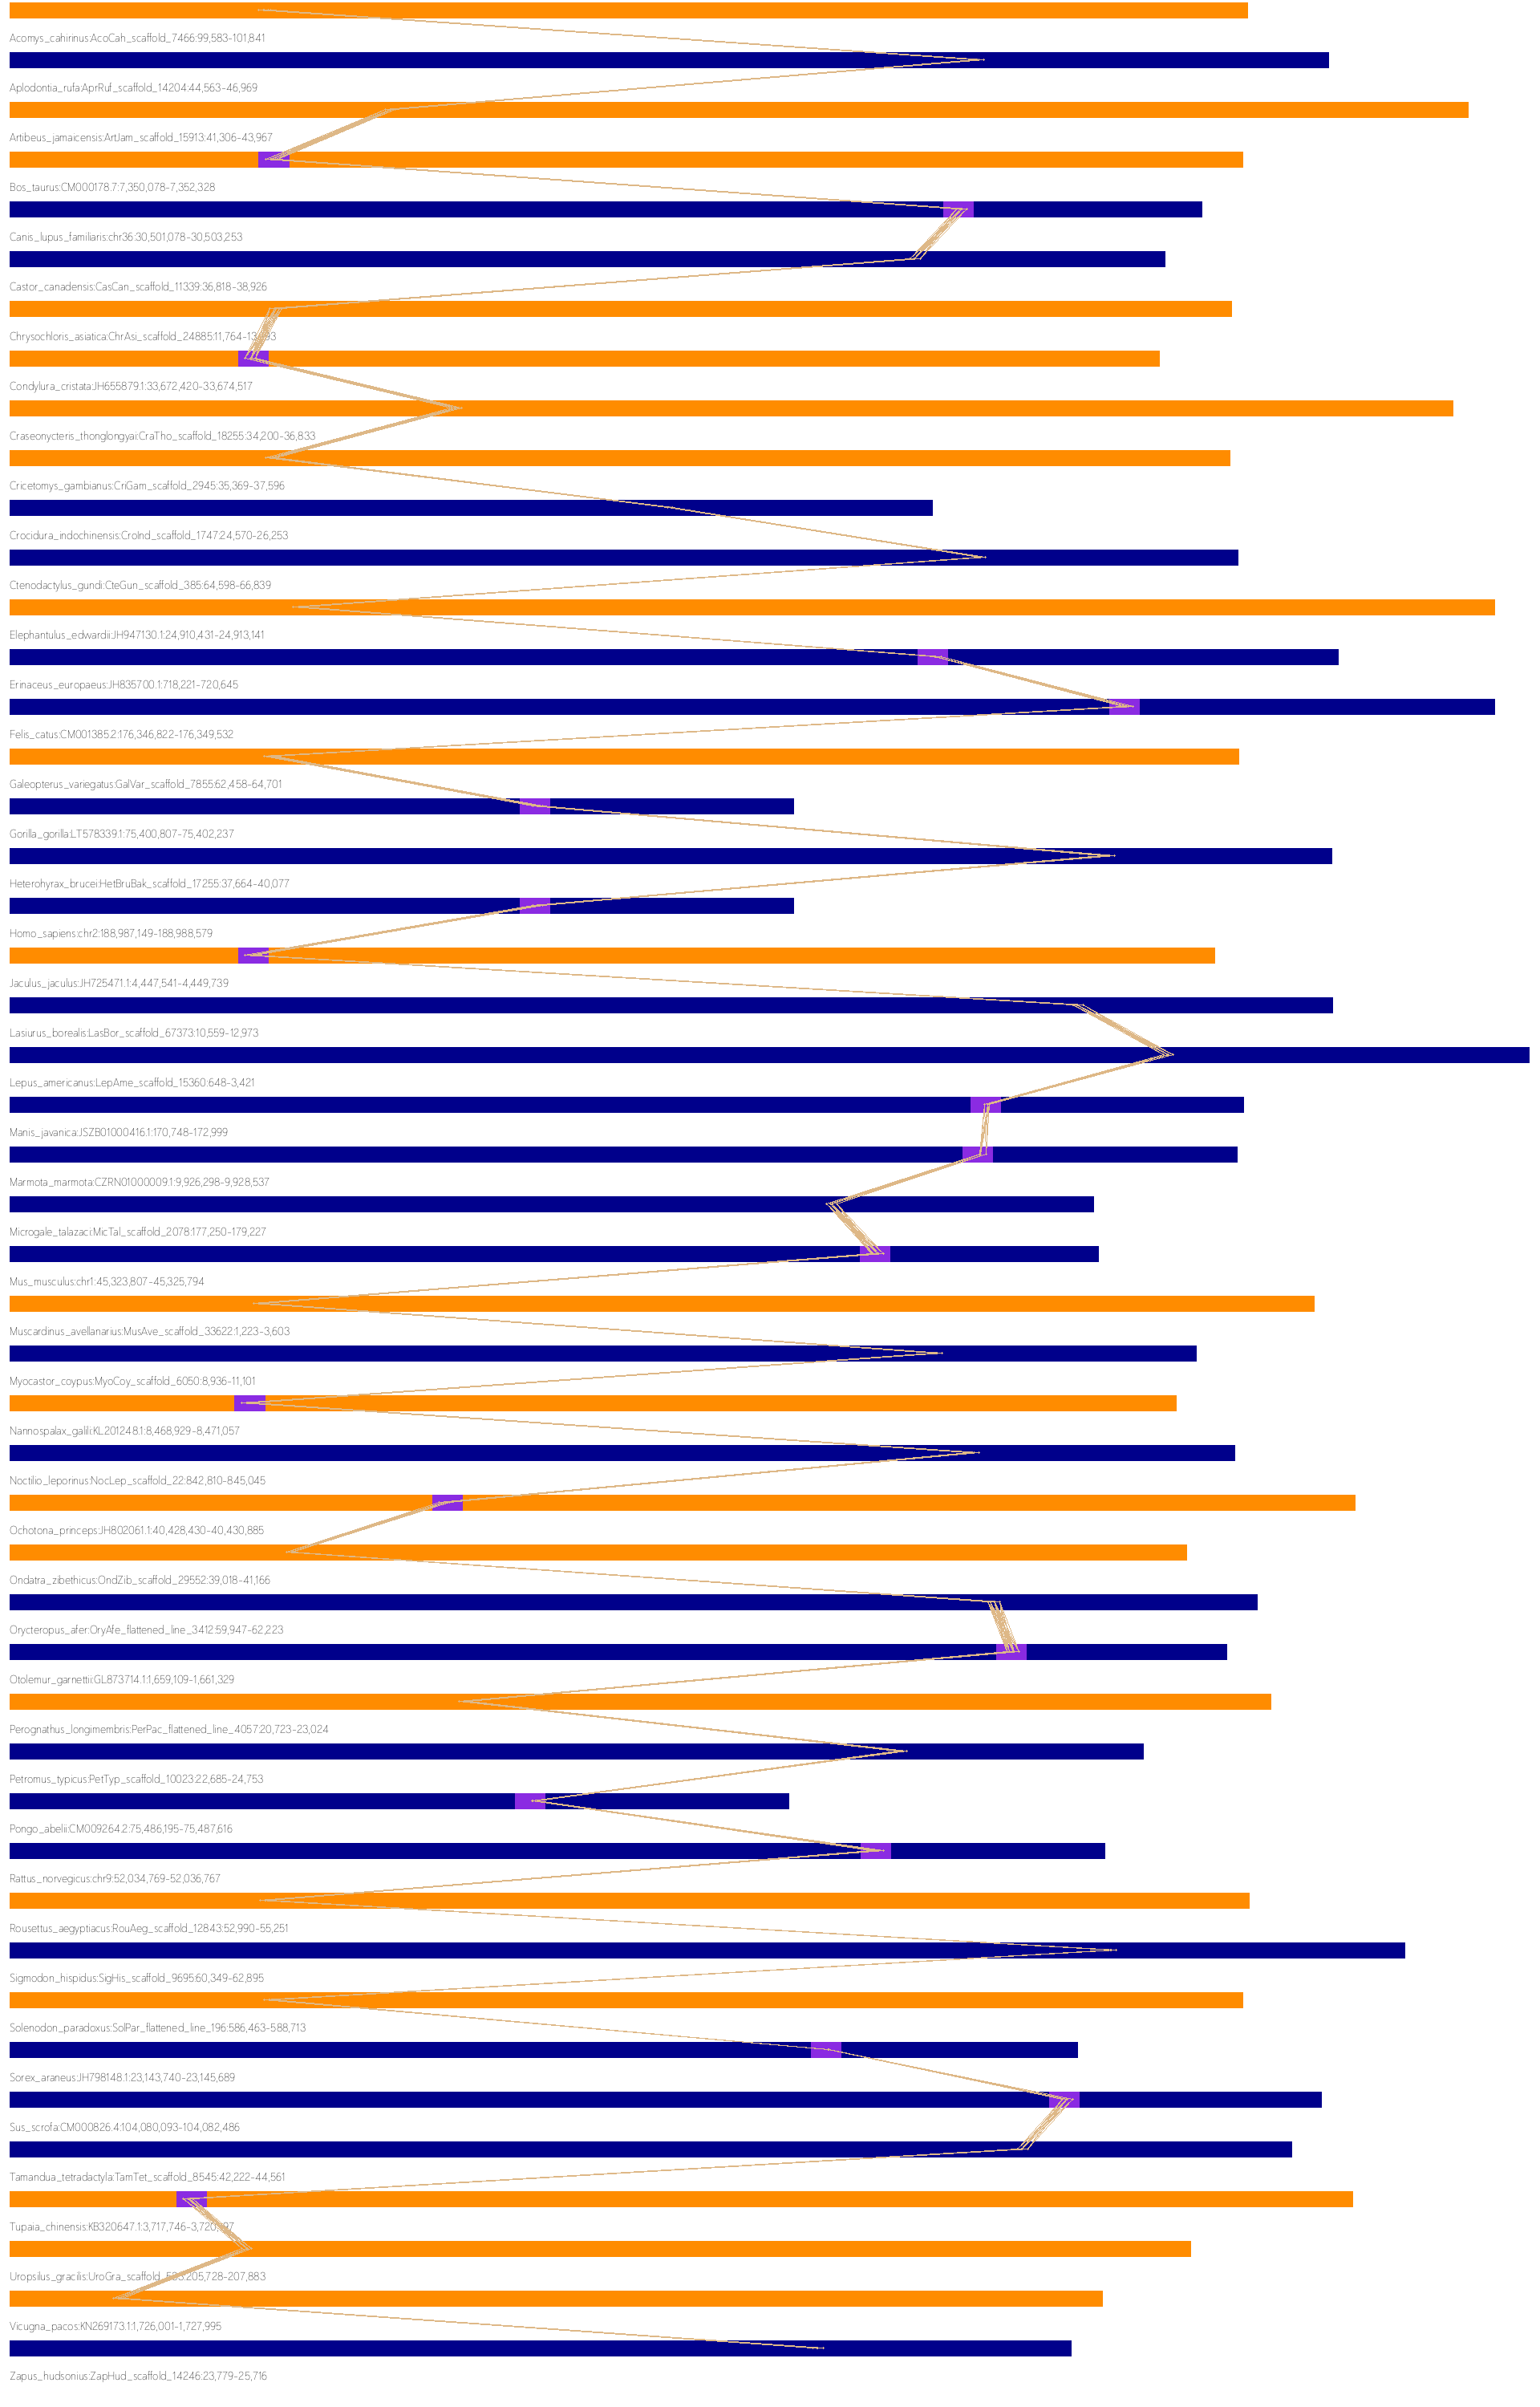

In [ ]:
plotting.drawGeneLinks(streme_eval.trainings[14].links)

Error: no "view" mailcap rules found for type "image/png"


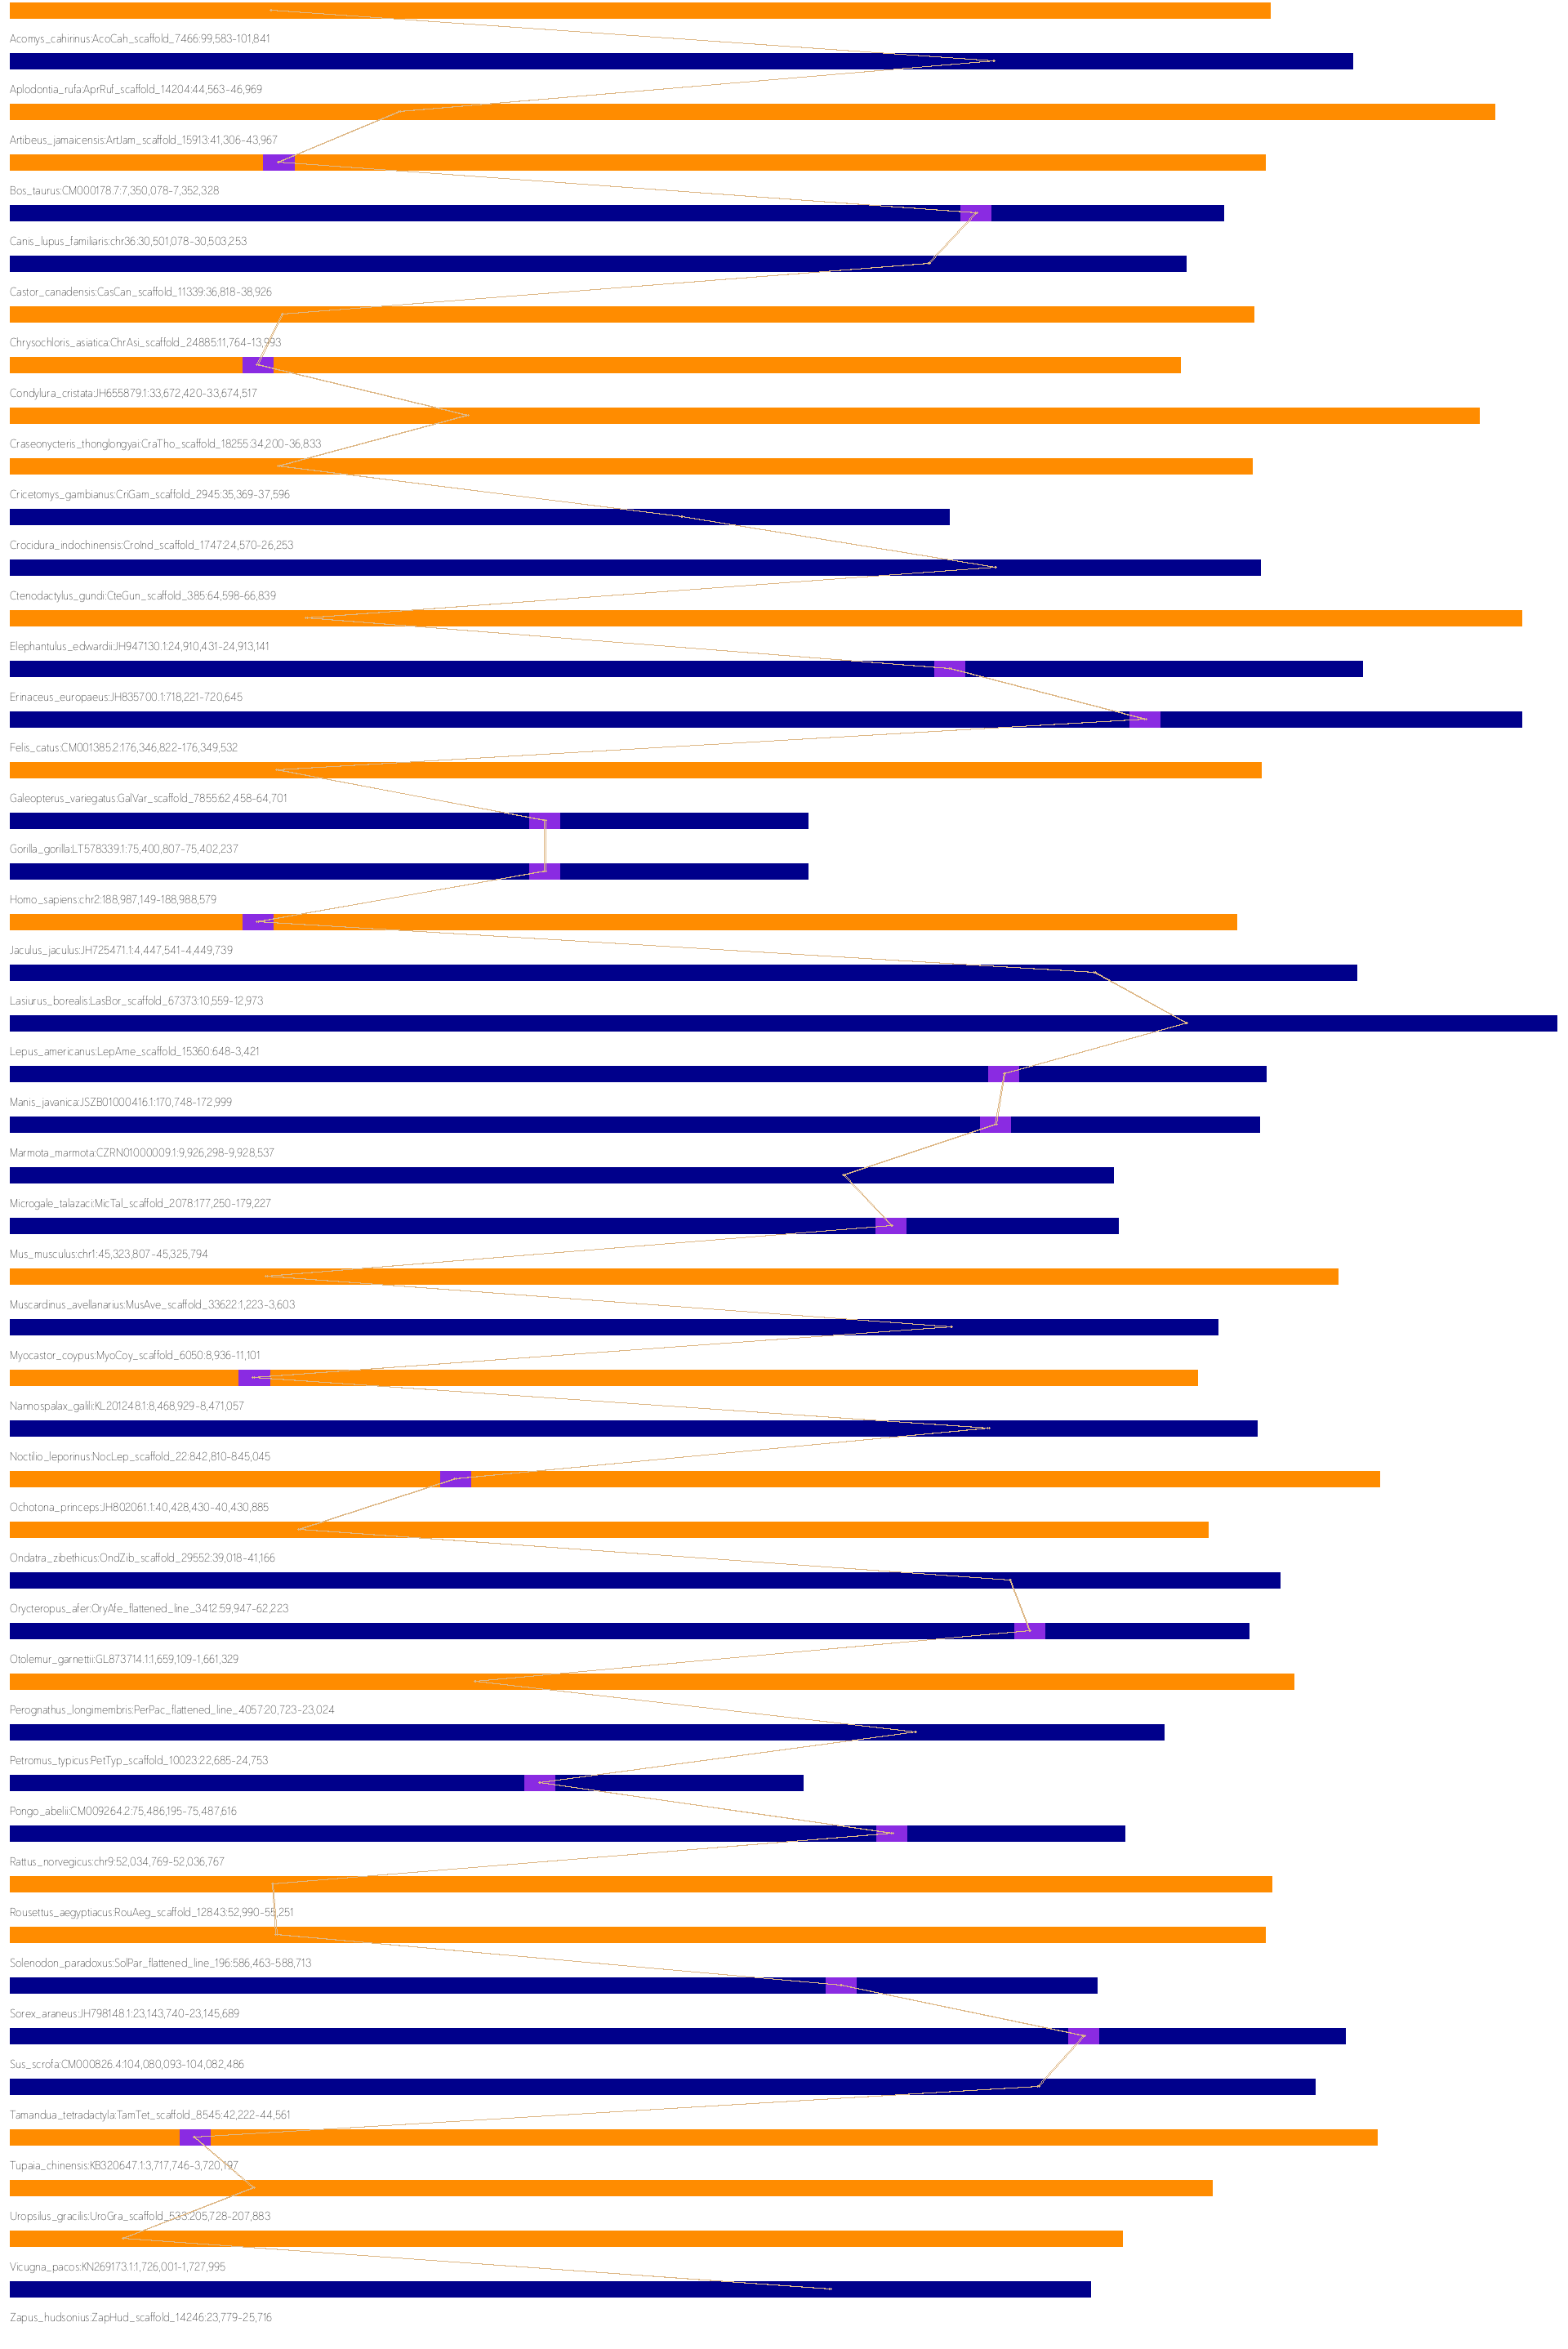

In [ ]:
plotting.drawGeneLinks(model_eval.trainings[14].links)

Info: old model performance:

    Number of sucessful runs in both models: 467

    INFO:root:[MultiTrainingEvaluation.accuracy] >>> Sensitivity: 21483 / 501361 = 0.042849364031107326
    INFO:root:[MultiTrainingEvaluation.accuracy] >>> Specificity: 423 / 449 = 0.9420935412026726
    INFO:root:[MultiTrainingEvaluation.accuracy] >>> Link Specificity: 21857 / 994 = 21.98893360160966
    INFO:root:[MultiTrainingEvaluation.accuracy] >>> Sensitivity: 20295 / 499223 = 0.04065317503400284
    INFO:root:[MultiTrainingEvaluation.accuracy] >>> Specificity: 855 / 862 = 0.9918793503480279
    INFO:root:[MultiTrainingEvaluation.accuracy] >>> Link Specificity: -578409682238359183495 / -7748743725467032315 = None
    Accuracy in model:  Sn = 0.042849364031107326, Sp = 0.9420935412026726
    Accuracy in streme: Sn = 0.04065317503400284, Sp = 0.9918793503480279

In [ ]:
t61 = model_eval.trainings[61]
t61.links

[[('Aotus_nancymaae:KZ207363.1:4,098,908-4,109,940', 10110, '-', 60, 0)
  ('Callicebus_donacophilus:CalDon_scaffold_54460:17,845-27,411', 538, '+', 60, 0)
  ('Callicebus_donacophilus:CalDon_scaffold_54460:17,845-27,411', 7501, '-', 60, 0)
  ('Callithrix_jacchus:NTIC01011113.1:41,983,585-41,994,333', 538, '+', 60, 0)
  ('Cebus_capucinus:KV389722.1:584,605-595,674', 539, '+', 60, 0)
  ('Cebus_capucinus:KV389722.1:584,605-595,674', 8851, '-', 60, 0)
  ('Cercocebus_atys:KQ011697.1:466,028-475,711', 9088, '-', 60, 0)
  ('Gorilla_gorilla:LT578334.1:40,315,470-40,328,706', 531, '+', 60, 0)
  ('Homo_sapiens:chr19:43,951,410-43,964,939', 866, '+', 60, 0)
  ('Pithecia_pithecia:PitPit_scaffold_46611:21,128-31,295', 1918, '+', 60, 0)
  ('Pithecia_pithecia:PitPit_scaffold_46611:21,128-31,295', 9573, '-', 60, 0)
  ('Pongo_abelii:CM009281.2:42,166,420-42,179,678', 531, '+', 60, 0)
  ('Saimiri_boliviensis:JH378321.1:587,848-599,305', 939, '+', 60, 0)
  ('Saimiri_boliviensis:JH378321.1:587,848-599,305'

In [ ]:
Links.linksFromMultiLinks(t61.links, 1000)

[Link(occs=[Aotus_nancymaae:KZ207363.1:4,098,908-4,109,940	p = 10110	-	u = 0, Callicebus_donacophilus:CalDon_scaffold_54460:17,845-27,411	p = 538	+	u = 0, Callithrix_jacchus:NTIC01011113.1:41,983,585-41,994,333	p = 538	+	u = 0, Cebus_capucinus:KV389722.1:584,605-595,674	p = 539	+	u = 0, Cercocebus_atys:KQ011697.1:466,028-475,711	p = 9088	-	u = 0, Gorilla_gorilla:LT578334.1:40,315,470-40,328,706	p = 531	+	u = 0, Homo_sapiens:chr19:43,951,410-43,964,939	p = 866	+	u = 0, Pithecia_pithecia:PitPit_scaffold_46611:21,128-31,295	p = 1918	+	u = 0, Pongo_abelii:CM009281.2:42,166,420-42,179,678	p = 531	+	u = 0, Saimiri_boliviensis:JH378321.1:587,848-599,305	p = 939	+	u = 0], span=60, expandMatchParameter=5, expandMismatchParameter=-4, expandScoreThreshold=20, expandX=100, _singleProfile=True),
 Link(occs=[Aotus_nancymaae:KZ207363.1:4,098,908-4,109,940	p = 10110	-	u = 0, Callicebus_donacophilus:CalDon_scaffold_54460:17,845-27,411	p = 538	+	u = 0, Callithrix_jacchus:NTIC01011113.1:41,983,585-41,994

# TODO: drawGeneLinks using MultiLinks for prettier images that distinguish profile matches better

Error: no "view" mailcap rules found for type "image/png"


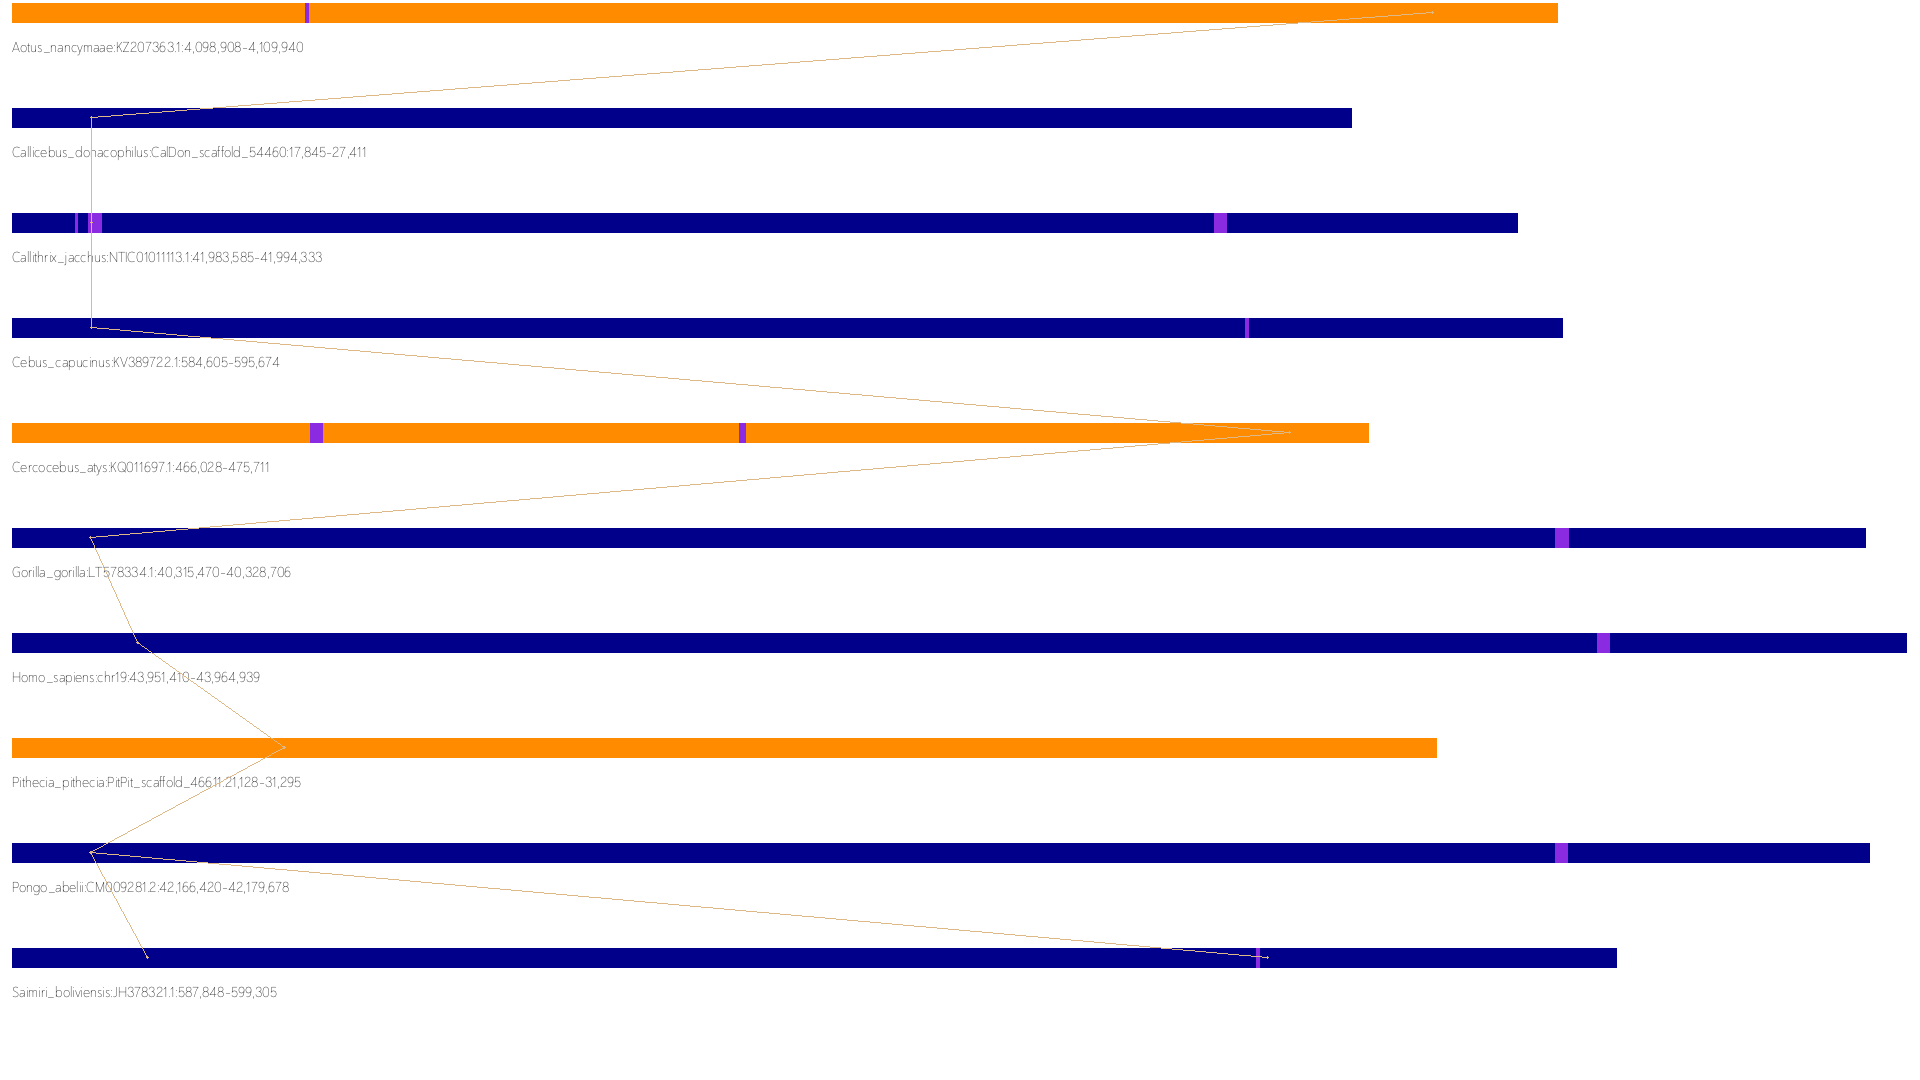

In [ ]:
plotting.drawGeneLinks(Links.linksFromMultiLinks(t61.links, 1000)[:2])

---

Run Stats

In [ ]:
import importlib
importlib.reload(plotting)

<module 'modules.plotting' from '/home/ebelm/genomegraph/learn_specific_profiles/modules/plotting.py'>

In [ ]:
# training time

maxtraintime = max([t.trainingTime for t in model_eval.trainings + streme_eval.trainings])
steps = 5 # minutes
bins = list(range(0, int(maxtraintime/60)+1, steps))
fig = plotting.ownPlotlyHist({'model': [t.trainingTime/60 for t in model_eval.trainings],
                              'streme': [t.trainingTime/60 for t in streme_eval.trainings]},
                             bins=bins)

fig.update_layout(title='Training time in minutes',
                  xaxis_title='Time in minutes',
                  yaxis_title='Frequency')

In [ ]:
# number of links per training

fig = plotting.ownPlotlyHist({'model': [t.nlinks for t in model_eval.trainings],
                              'streme': [t.nlinks for t in streme_eval.trainings]})
fig.update_layout(title='Number of links per training',
                  xaxis_title='nlinks',
                  yaxis_title='Frequency')

In [ ]:
# discard runs with nlinks > 100

fig = plotting.ownPlotlyHist({'model': [t.nlinks for t in model_eval.trainings if t.nlinks <= 100],
                              'streme': [t.nlinks for t in streme_eval.trainings if t.nlinks <= 100]})
fig.update_layout(title='Number of links per training',
                  xaxis_title='nlinks',
                  yaxis_title='Frequency')

In [ ]:
idx = [i for i, t in enumerate(streme_eval.trainings) if t.nlinks > 100]
streme_eval.trainings[idx[0]].runID

'0123'

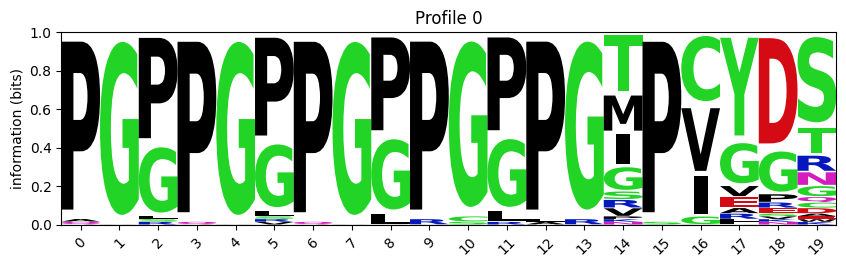

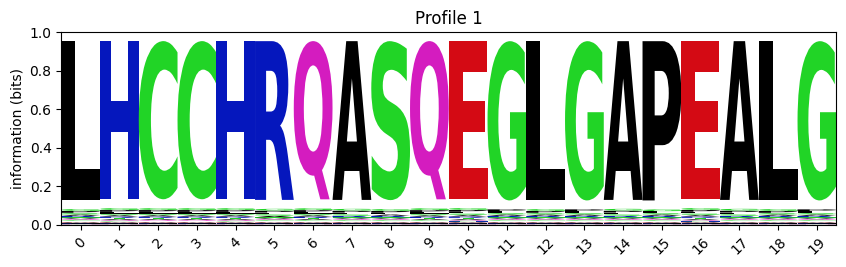

In [ ]:
i = idx[0]
plotting.plotLogo(streme_eval.trainings[i].motifs.motifs,
                  alphabet=streme_eval.trainings[i].motifs.metadata['alphabet'])

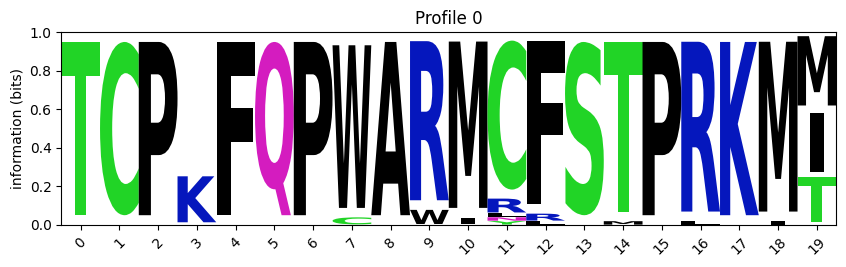

In [ ]:
plotting.plotLogo(model_eval.trainings[i].motifs.motifs)

In [ ]:
testeval = training.MultiTrainingEvaluation()
testeval.trainings.append(streme_eval.trainings[0])
testeval.accuracy()

INFO:root:[MultiTrainingEvaluation.accuracy] >>> Sensitivity: 0 / 1 = 0.0
INFO:root:[MultiTrainingEvaluation.accuracy] >>> Specificity: 0 / 2 = 0.0


(0.0, 0.0)

---

In [ ]:
assert False

AssertionError: 